This notebook is for developing suplemental figure 4.

It works together with scripts "deploy_shuffle_clustering.py" and "run_shuffle_clustering.py" which are in vba repo, to generate shuffled datasets, coclustering matrices and labels for each type of shuffle.

For the scope of supplemental figure 4, we are using "experience", "experience_within_cell", and "full_experience" shuffle types for figures.



In [1]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\data_access\loading.py:53: UserWarning: failed to set up LIMS/mtrain credentials
'MTRAIN_DBNAME'

internal AIBS users should set up environment variables appropriately
functions requiring database access will fail
  warnings.warn(warn_string)


In [2]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [6]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


3921 cells in matched cells table


In [8]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [9]:
# set params for saving
folder = '220809_shuffle_suppl_figures'
file_dir = '220627_shuffle_test/files' # output of run_shuffle_clustering.py script from hpc

In [10]:
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [11]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix,, meta data and cluster labels

In [12]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(base_dir,file_dir, filename), key='df')

In [13]:
filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [14]:
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [15]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].index.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

In [16]:
original_cluster_labels.head(2)

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2


#### compute mean dropout scores for original data

In [17]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    # This is a band-aid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    if cre_line == 'Slc17a7-IRES2-Cre':
        print('changing stuff')
        mean_dropout_scores=mean_dropout_scores.rename(columns= {4:5,5:4})
        mean_dropout_scores = mean_dropout_scores.reindex(sorted(mean_dropout_scores), axis=1)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

changing stuff


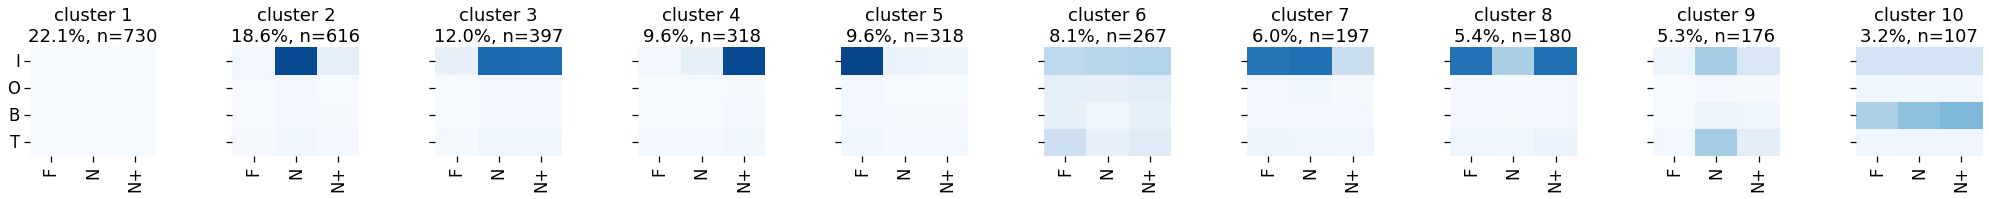

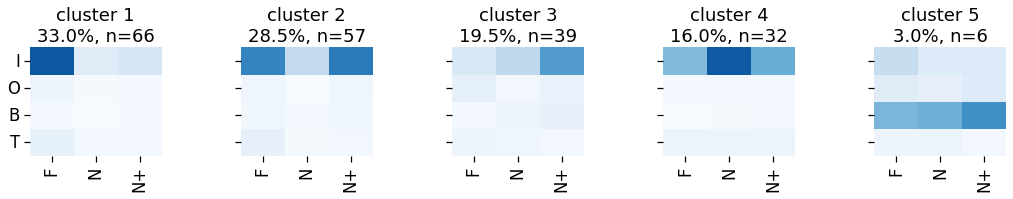

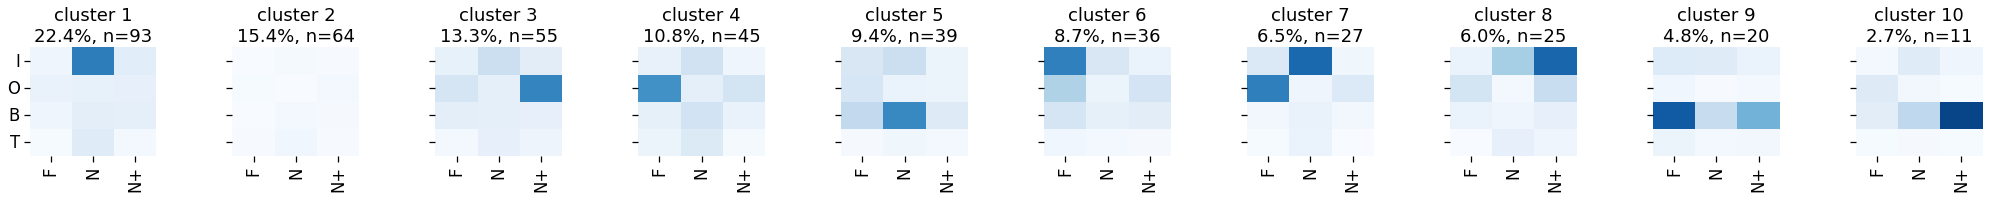

In [18]:
# plot original clusters
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


In [19]:
shuffle_types = ['experience','experience_within_cell','full_experience']
n_boots = np.arange(150)

#### load shuffled datasets into one dictionary

In [20]:
%%time
# this takes a few minutes
shuffle_type_df = {}
for shuffle_type in shuffle_types:
    cre_df_shuffled = {}
    for cre_line in cre_lines:
        nb_shuffled = {}
        for n_boot in n_boots:
            nb_filename ='{}_{}_nb{}.h5'.format(cre_line, shuffle_type, n_boot)
            
            try:
                nb_shuffled[n_boot] = pd.read_hdf(os.path.join(base_dir, file_dir, nb_filename), key = 'df')
            except:
                print(f'did not find nboot {n_boot}')
        cre_df_shuffled[cre_line] = nb_shuffled
    shuffle_type_df[shuffle_type] = cre_df_shuffled

Wall time: 1min 18s


#### load cluster labels for each dataset into one dictionary

In [23]:
%%time
shuffle_type_labels = {}
for shuffle_type in shuffle_types:
    cre_labels_shuffled = {}
    for cre_line in cre_lines:
        nb_labels_shuffled = {}
        for n_boot in n_boots:
            nb_filename ='{}_{}_nb{}_cluster_labels.h5'.format(cre_line, shuffle_type, n_boot) 
            full_filename = os.path.join(base_dir, file_dir, nb_filename)
        
            nb_labels_shuffled[n_boot] = pd.read_hdf(full_filename, key = 'clustered_df')
        cre_labels_shuffled[cre_line] = nb_labels_shuffled
    shuffle_type_labels[shuffle_type] = cre_labels_shuffled

Wall time: 1min 36s


#### compute mean dropout scores for shuffled dfs


In [24]:
shuffle_type_mean_dropout_scores = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n_boot in n_boots:
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n_boot]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n_boot]
            #cluster_df = cluster_df.rename(mapper={'labels':'cluster_id'}, axis=1)
            mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df)
            nb_mean_dropout_scores_shuffled[n_boot] = mean_dropout_scores
        cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores[shuffle_type] = cre_mean_dropout_scores_shuffled

In [24]:
### this takes a lot of time so run it at your own risk
### plot clusters
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         for n_boot in n_boots:
#             feature_matrix = shuffle_type_df[shuffle_type][cre_line][n_boot]
#             cluster_df = shuffle_type_labels[shuffle_type][cre_line][n_boot].set_index('cell_specimen_id')
#             sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
#             vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
#                                    sort_order=sort_order, save_dir=save_dir, folder='shuffled_plots', 
#                                         suffix='_nb'+str(n_boot)+'_'+shuffle_type, formats=['.png'])
#             plt.close('all')

### compute SSE

In [29]:
shuffle_type_SSE = {}
for shuffle_type in shuffle_types:
    cre_SSE = {}
    for cre_line in cre_lines:
        nb_sse = {}
        original_df = cre_mean_dropout_scores[cre_line]
        for n_boot in n_boots:
            shuffled_df = shuffle_type_mean_dropout_scores[shuffle_type][cre_line][n_boot]
            sse = vba_clust.compute_SSE(original_df, shuffled_df)
            nb_sse[n_boot] = sse
        cre_SSE[cre_line] = nb_sse
    shuffle_type_SSE[shuffle_type] = cre_SSE
        



### get cluster mapping

In [30]:
shuffle_type_SSE_mapping = {}
for shuffle_type in shuffle_types:
    cre_SSE_mapping = {}
    for cre_line in cre_lines:
        nb_sse_mapping = {}
        nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
        cluster_mapping = vba_clust.get_cluster_mapping(nb_matrix, threshold = 0.05)
        cre_SSE_mapping[cre_line] = cluster_mapping
    shuffle_type_SSE_mapping[shuffle_type] = cre_SSE_mapping


#### need to plot aligned clusters into one folder
Each matched cluster, correlation coeff between matched clusters and original cluster, and mean matched cluster

In [31]:
#create unstacked mean dropout scores for ach cluster for plotting
shuffle_type_mean_dropout_scores_unstacked = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled_unstacked = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n_boot in n_boots:
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n_boot]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n_boot]
            #cluster_df = cluster_df.rename(mapper={'labels':'cluster_id'}, axis=1)
            mean_dropout_scores_unstacked = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df, stacked=False)
            nb_mean_dropout_scores_shuffled[n_boot] = mean_dropout_scores_unstacked
        cre_mean_dropout_scores_shuffled_unstacked[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores_unstacked[shuffle_type] = cre_mean_dropout_scores_shuffled_unstacked

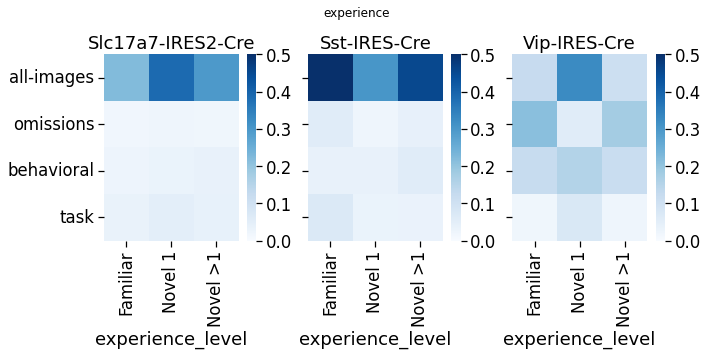

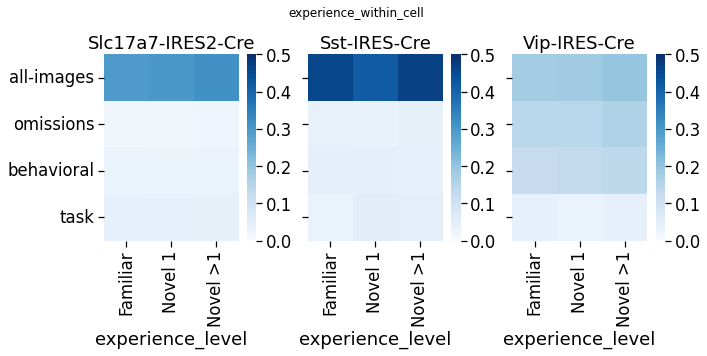

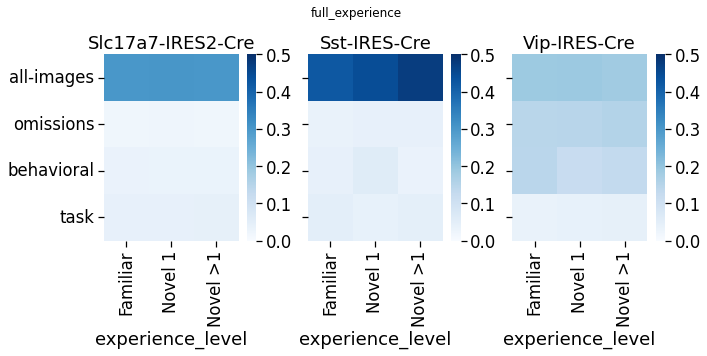

In [32]:
### pot mean of shuffled dropout scores regardless of clusters.
for shuffle_type in shuffle_types:
    fig, ax = plt.subplots(1,3, figsize = (10,5), sharey='row')
    for c, cre_line in enumerate(cre_lines):
        for n_boot in n_boots:
            if n_boot ==0:
                dropout_scores = shuffle_type_df[shuffle_type][cre_line][n_boot]
            else:
                dropout_scores.append(shuffle_type_df[shuffle_type][cre_line][n_boot], ignore_index=True)
        mean_df = dropout_scores.mean().unstack()
        features = vba_clust.get_features_for_clustering()
        mean_df = mean_df.loc[features]
        ax[c] = sns.heatmap(mean_df, cmap='Blues', ax=ax[c], vmin=0, vmax=0.5)
        ax[c].set_title(cre_line)
    plt.suptitle(shuffle_type)
    plt.tight_layout()
    utils.save_figure(fig, figsize = (10,5), save_dir=save_dir, folder='', fig_title=f'mean_dropout_scores_{shuffle_type}')

In [49]:

# This takes forever, so commenting it out unless it's needed
# plot
vmin = 0
cmap = 'Blues'

shuffle_types = shuffle_type_SSE_mapping.keys()
for shuffle_type in shuffle_types:
    
    cre_lines = shuffle_type_SSE_mapping[shuffle_type].keys()
    for cre_line in cre_lines:
        
        n_boots = shuffle_type_SSE_mapping[shuffle_type][cre_line].keys()
        for n_boot in n_boots:
            
            cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].keys()
            for cluster_id in cluster_ids:
                matched_cluster_id = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot][cluster_id]
                if matched_cluster_id !=-1:
                    dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][matched_cluster_id]

                    # plot cluster
                    fig, ax = plt.subplots()    
                    sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
                    ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

                    # save
                    this_folder = os.path.join('matched_plots',shuffle_type, cre_line[:3], f'cluster_{cluster_id}')
                    this_dir = os.path.join(save_dir, this_folder)
                    if not os.path.exists(this_dir):
                        os.mkdir(this_dir)    
                    plt.tight_layout()
                    figname = 'nb_{}.png'.format(n_boot)
                    fig.savefig(os.path.join(this_dir, figname))

                    plt.close('all')
            
            # plot all unmatched clusters into one folder
            # all matched cluster ids
            matched_cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].values()
            for cluster_id in cluster_ids:
                # if it is not in matched cluster ids, plot and save into unmatched folder
                if cluster_id not in matched_cluster_ids:
                    dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][cluster_id]
                    # plot cluster
                    fig, ax = plt.subplots()    
                    sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
                    ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

                    # save
                    this_folder = os.path.join('matched_plots',shuffle_type, cre_line[:3], 'unmatched')
                    this_dir = os.path.join(save_dir, this_folder)
                    if not os.path.exists(this_dir):
                        os.mkdir(this_dir)    
                    plt.tight_layout()
                    figname = 'nb_{}_cluster_id_{}.png'.format(n_boot, cluster_id)
                    fig.savefig(os.path.join(this_dir, figname))

                    plt.close('all')
            

In [33]:
shuffle_type_probabilities = {}
for shuffle_type in shuffle_types:
    cre_cluster_probabilities = {}
    for cre_line in cre_lines:
        SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
        cre_cluster_probabilities[cre_line] = vba_clust.compute_probabilities(SSE_mapping)
    shuffle_type_probabilities[shuffle_type] = cre_cluster_probabilities

In [35]:
for shuffle_type in shuffle_types:
    filename = 'cre_cluster_probabilities_{}_220809.pkl'.format(shuffle_type)
    vba_clust.save_clustering_results(shuffle_type_probabilities[shuffle_type], os.path.join(save_dir, filename))

In [36]:
shuffle_type_cluster_sizes = {}
for shuffle_type in shuffle_types:
    cre_cluster_sizes = {}
    for cre_line in cre_lines:
        SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
        cluster_df_shuffled = shuffle_type_labels[shuffle_type][cre_line]
        all_cluster_sizes = vba_clust.get_cluster_size_variance(SSE_mapping, cluster_df_shuffled)
        cre_cluster_sizes[cre_line] = all_cluster_sizes 
    shuffle_type_cluster_sizes[shuffle_type] = cre_cluster_sizes

In [37]:
for shuffle_type in shuffle_types:
    filename = 'cre_cluster_sizes_{}_220809.pkl'.format(shuffle_type)
    vba_clust.save_clustering_results(shuffle_type_cluster_sizes[shuffle_type], os.path.join(save_dir, filename))

### Plot proportions for matched clusters

In [38]:
cre_original_cluster_sizes = {}
for cre_line in cre_lines:
    tmp = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    cre_original_cluster_sizes[cre_line] = tmp.value_counts('cluster_id')
    

In [39]:
cluster_size_difference_df = vba_clust.get_cluster_size_differece_df(cre_original_cluster_sizes, shuffle_type_cluster_sizes)

#### statistics on cluster sizes

In [40]:
 for cre_line in cre_lines:
    for shuffle_type in shuffle_types:
        cluster_ids = cre_original_cluster_sizes[cre_line].keys()
        for cluster_id in cluster_ids:
            x = cre_original_cluster_sizes[cre_line][cluster_id]
            y_list = shuffle_type_cluster_sizes[shuffle_type][cre_line][cluster_id]
            y_new = [y for y in y_list if np.isnan(y) == False]
            

#### compute probabilities

In [41]:
shuffle_probability_df = vba_clust.get_cluster_probability_df(shuffle_type_probabilities)

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2693: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.round(ax[i].get_yticks(), 1), color=color1)
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2709: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax2.get_yticks(), 1), color=color2)
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2693: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.round(ax[i].get_yticks(), 1), color=color1)
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:2709: UserWarning: FixedForm

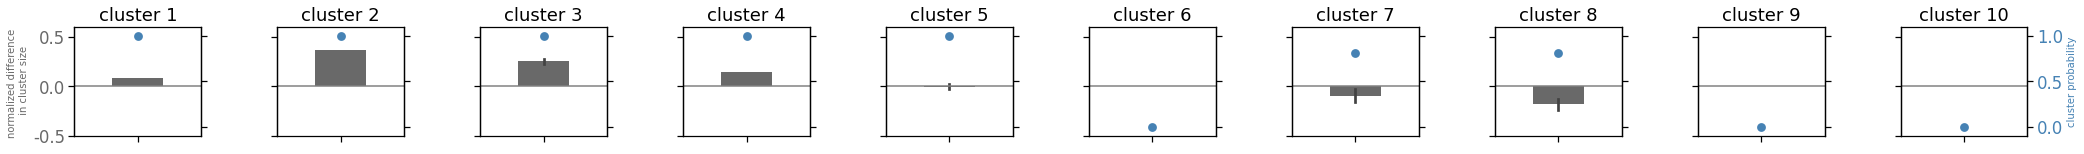

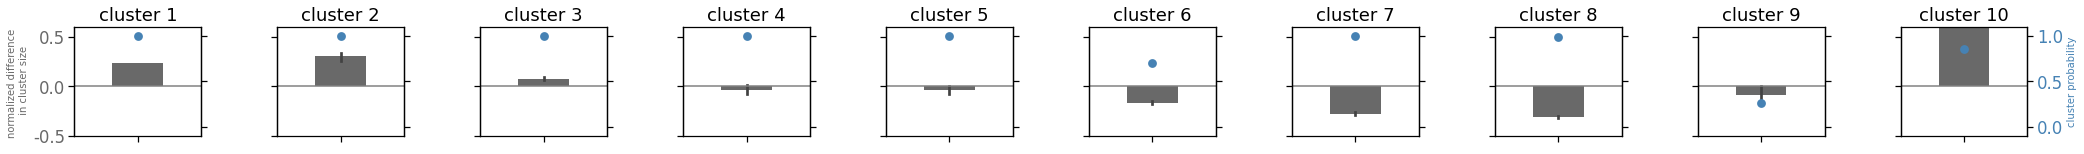

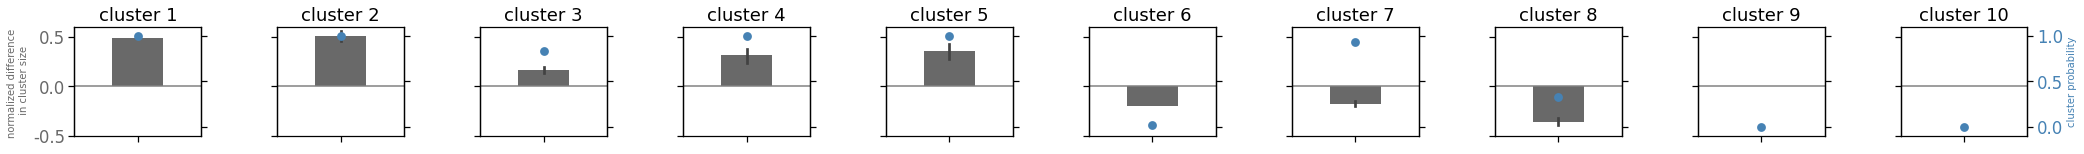

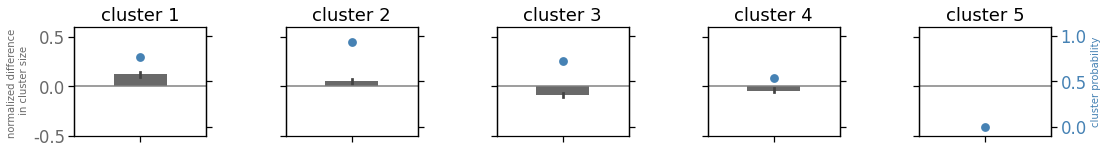

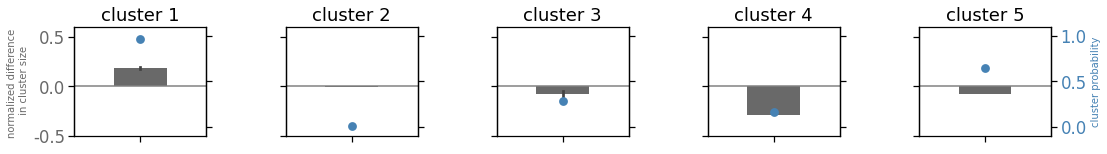

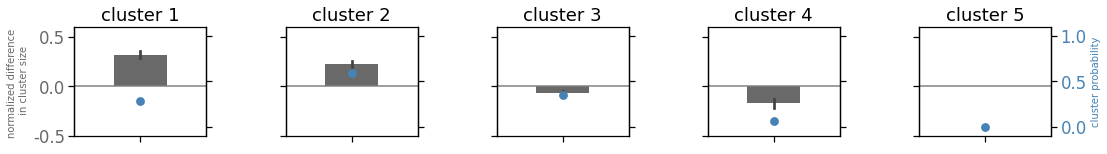

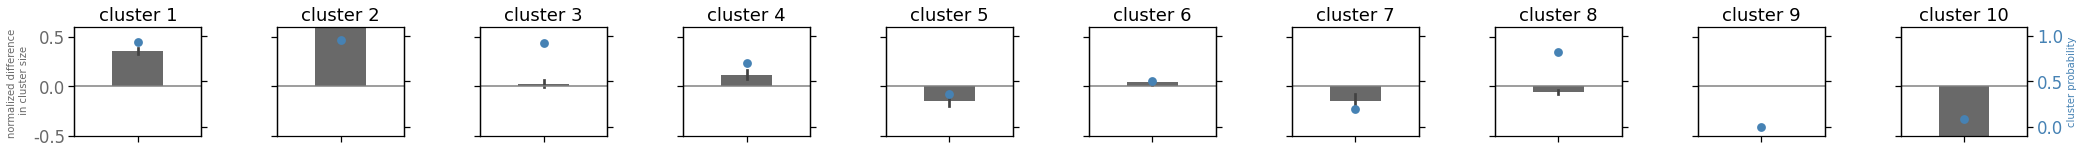

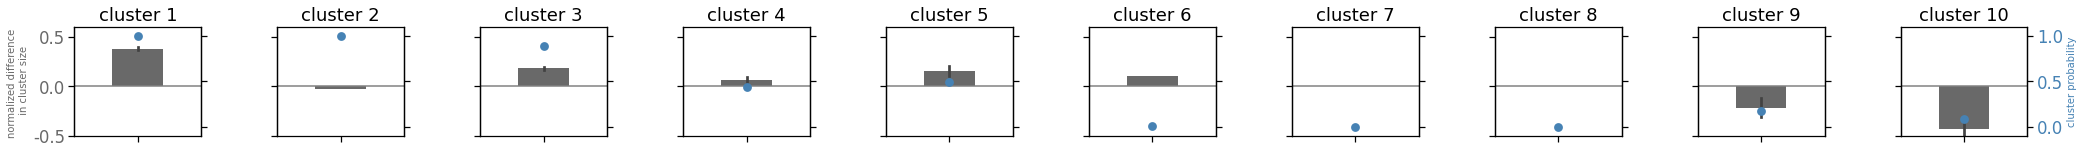

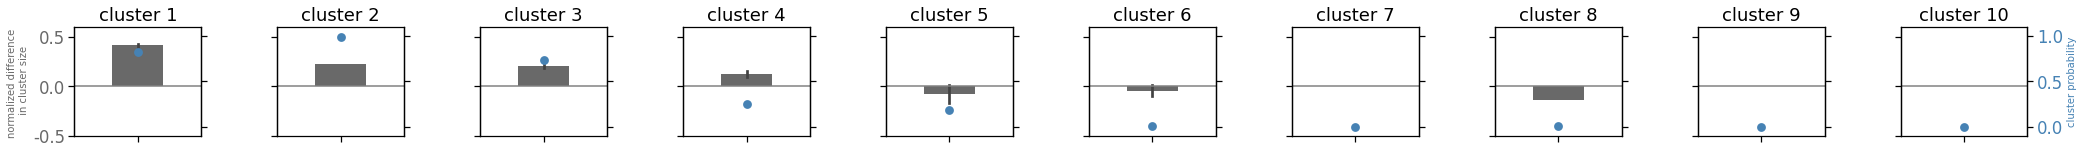

In [42]:
for cre_line in cre_lines:
    for s, shuffle_type in enumerate(shuffle_types):
        vba_clust.plot_cluster_size_and_probability(cluster_size_difference_df, 
                                                    shuffle_probability_df, 
                                                    cre_line=cre_line, 
                                                    shuffle_type=shuffle_type,
                                                   save_dir=save_dir,
                                                   folder = 'probability_size_plots')
        

#### plot mean heatmap of matched clusters

to do:
    fix this plotting function

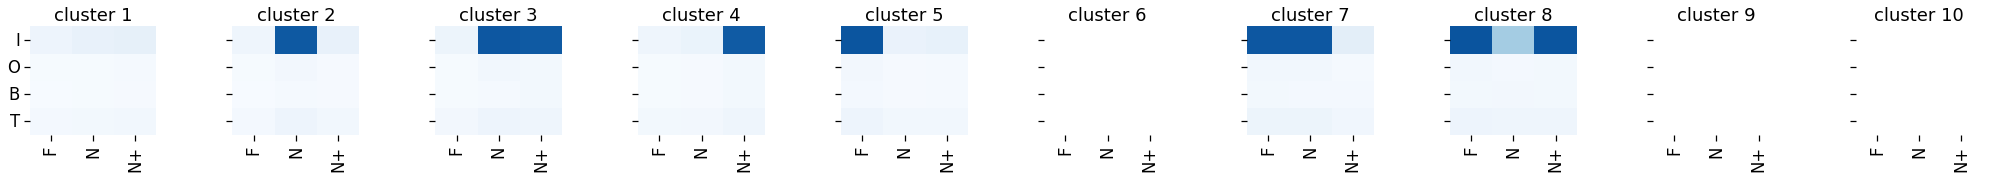

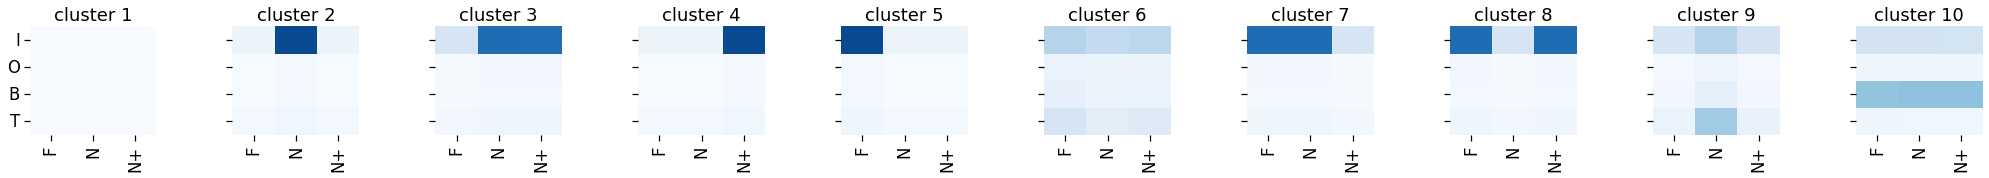

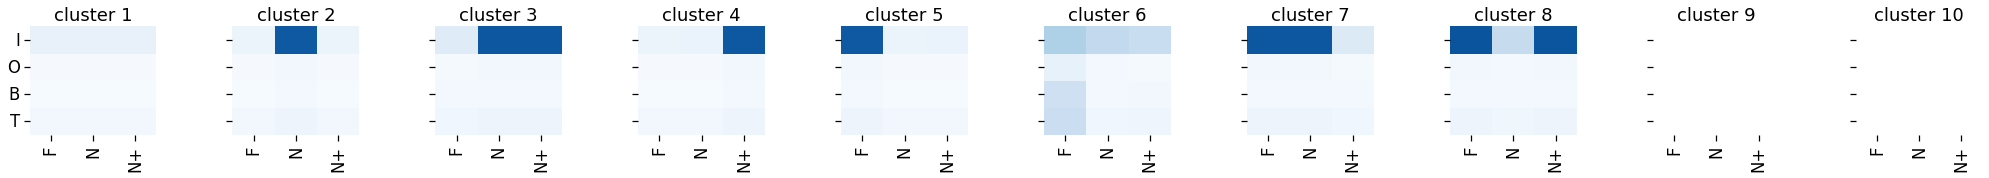

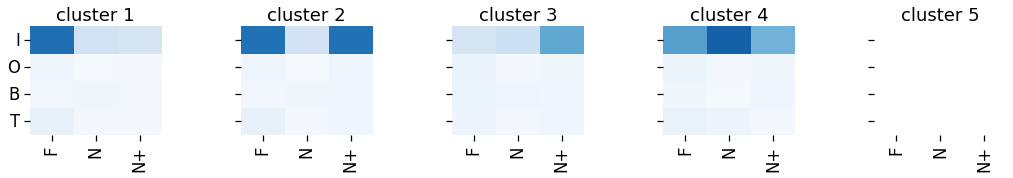

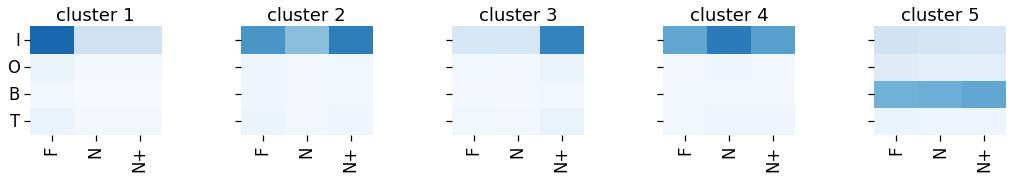

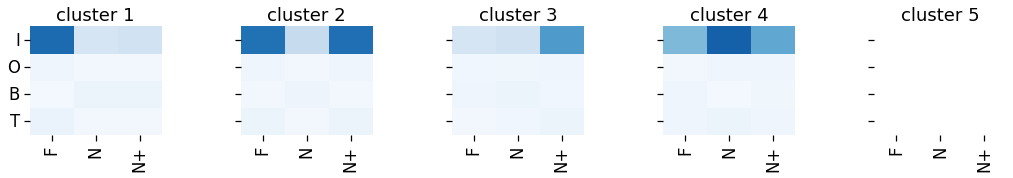

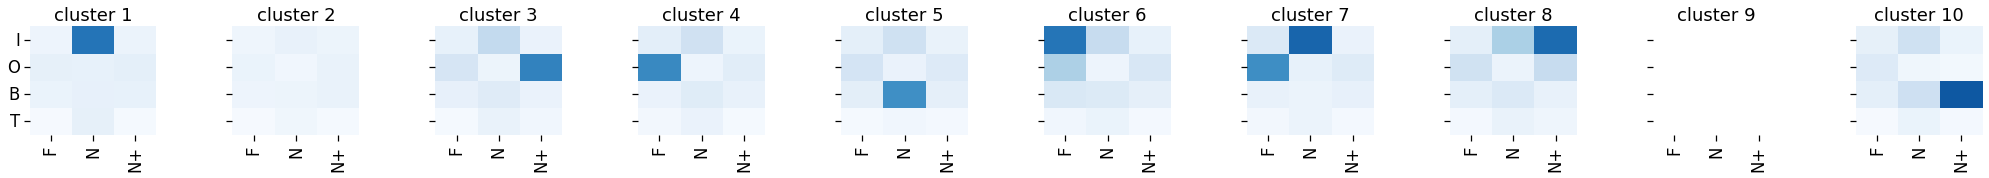

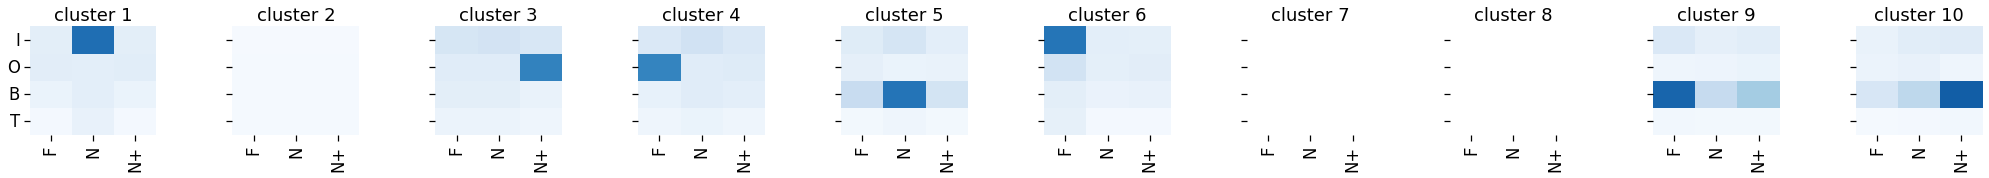

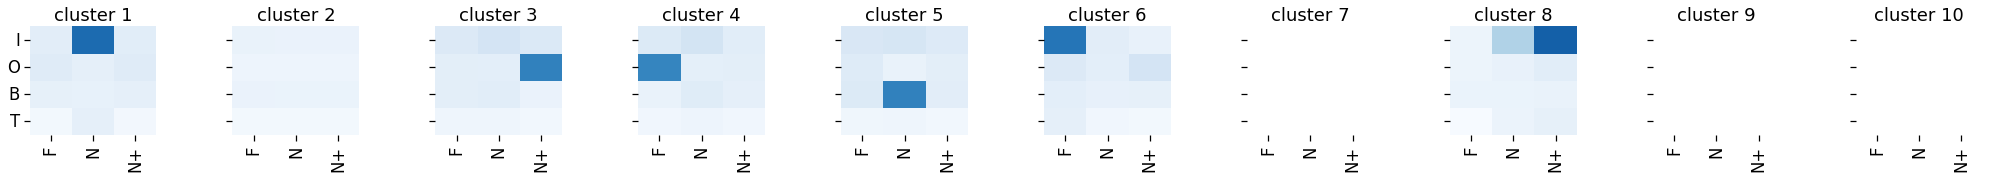

In [43]:
for cre_line in cre_lines:
    for shuffle_type in shuffle_types:
        vba_clust.plot_matched_clusters_heatmap(SSE_mapping = shuffle_type_SSE_mapping, 
                                                mean_dropout_scores_unstacked= shuffle_type_mean_dropout_scores_unstacked ,
                                                cre_line=cre_line, metric='mean',
                                                shuffle_type=shuffle_type, save_dir=save_dir, folder='')

        

### writing correlation function

In [39]:
from scipy.stats import spearmanr

In [40]:
def get_corr_for_matched_clusters_dict(SSE_mapping, mean_shuffled_dropout_scores, 
                                   mean_original_dropout_scores=None,
                                   cre_line=None, shuffle_type=None, 
                                   use_spearman = True,):
    
    # set up the variables
    if shuffle_type is not None:
        SSE_mapping = SSE_mapping[shuffle_type]
        mean_shuffled_dropout_scores = mean_shuffled_dropout_scores[shuffle_type]
        
    if cre_line is not None:
        SSE_mapping = SSE_mapping[cre_line]
        mean_shuffled_dropout_scores = mean_shuffled_dropout_scores[cre_line]
        if mean_original_dropout_scores is not None:
            mean_original_dropout_scores = mean_original_dropout_scores[cre_line]
    
    n_boots = SSE_mapping.keys()
    cluster_ids = SSE_mapping[0].keys()
    
    cluster_corr_dict = {}
    for cluster_id in cluster_ids:
        # X is a list of mean dropout scores of matched cluster per shuffle
        X = []
        
        if mean_original_dropout_scores is not None:
            Y = mean_original_dropout_scores[cluster_id].values
            
        print(f'finding matched clusters for cluster id {cluster_id}')
        for n_boot in n_boots:
            matched_cluster_id = SSE_mapping[n_boot][cluster_id]
            if matched_cluster_id != -1:
                X.append(mean_shuffled_dropout_scores[n_boot][matched_cluster_id].values)
        
        # corr is a np.array of corr rs for all matched clusters (with original or one another)
        corr = np.array([])
        # compute corr values just for shuffled clusters
        if mean_original_dropout_scores is None and np.size(X) != 0:
            if use_spearman is True:
                print(f'computing spearman r between {len(X)} matched clusters')
                if len(X) > 1:
                    corr = spearmanr(X, axis=1)[0]
                else:
                    corr = spearmanr(X)[0]
            else:
                print(f'computing pearson r between {len(X)} matched clusters')
                corr = np.corrcoef(X)
                
            # use half of identity matrix only
            if np.shape(X)[0] > 1 and np.size(corr)>1:
                
                indices = np.triu_indices_from(corr, k = 1)
                corr = corr[indices]
        
        # compute correlation values of original with shuffled clusters
        elif np.size(X) != 0:
            if use_spearman is True:
                print(f'computing spearman r between original and {len(X)} matched clusters')
                #use only one row of X corr with Y, exclude autocorr 
                if np.size(X) > 12: 
                    corr = spearmanr(X, Y, axis=1)[0][-1][:-1] 
                else: # if only one cluster is matched
                    corr = spearmanr(X, Y, axis=1)[0]
            else:
                print(f'computing pearson r between original and {len(X)} matched clusters')
                if np.size(X) > 12:
                    corr = np.corrcoef(X, Y)[-1][:-1]
                else: # if only one cluster is matched
                    corr = np.corrcoef(X, Y)
        
        # add mean and std values to cluster_corr_dict
        if np.size(corr) !=0:
            cluster_corr_dict[cluster_id] = [np.mean(corr), np.std(corr)]
        else:
            print(f'did not find any matched clusters for cluster id {cluster_id}')
            cluster_corr_dict[cluster_id] = [np.nan, np.nan]
            
    return cluster_corr_dict    
    

In [41]:
shuffle_corr_dict = {}
for shuffle_type in shuffle_types:
    corr_dict = {}
    for cre_line in cre_lines:
        corr_dict[cre_line]= get_corr_for_matched_clusters_dict(shuffle_type_SSE_mapping, 
                                                       shuffle_type_mean_dropout_scores,
                                                        shuffle_type = shuffle_type,
                                                       cre_line = cre_line)
    shuffle_corr_dict[shuffle_type] = corr_dict                         

finding matched clusters for cluster id 1
computing spearman r between 150 matched clusters
finding matched clusters for cluster id 2
computing spearman r between 150 matched clusters
finding matched clusters for cluster id 3
computing spearman r between 125 matched clusters
finding matched clusters for cluster id 4
computing spearman r between 150 matched clusters
finding matched clusters for cluster id 5
computing spearman r between 150 matched clusters
finding matched clusters for cluster id 6
computing spearman r between 3 matched clusters
finding matched clusters for cluster id 7
computing spearman r between 140 matched clusters
finding matched clusters for cluster id 8
computing spearman r between 49 matched clusters
finding matched clusters for cluster id 9
did not find any matched clusters for cluster id 9
finding matched clusters for cluster id 10
did not find any matched clusters for cluster id 10
finding matched clusters for cluster id 1
computing spearman r between 43 match

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


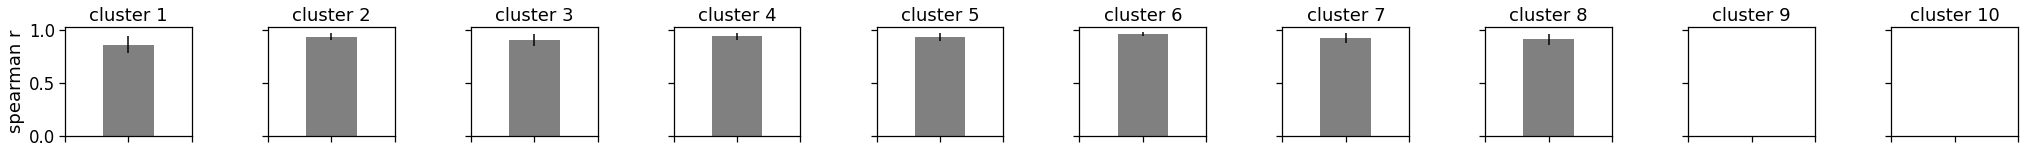

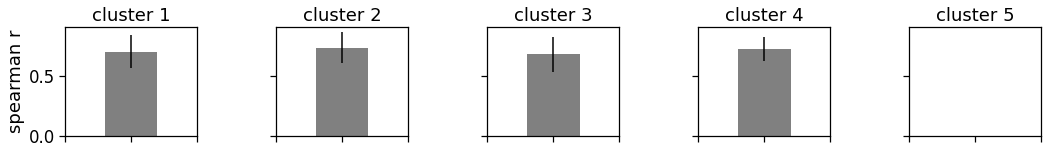

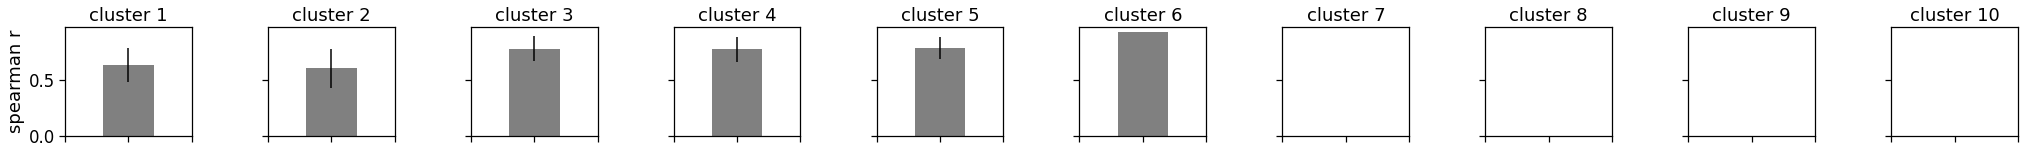

In [42]:
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        corr_dict = shuffle_corr_dict[shuffle_type][cre_line]
        n_clusters = len(corr_dict.keys())
        figsize=(3.5*n_clusters,2)
        fig, ax = plt.subplots(1,n_clusters, figsize = figsize, sharey='row')
        for i, cluster_id in  enumerate(corr_dict.keys()):
            ax[i].bar(cluster_id, corr_dict[cluster_id][0], color='Grey')
            ax[i].errorbar(cluster_id, corr_dict[cluster_id][0], corr_dict[cluster_id][1], 
                        color='k')
            ax[i].set_xticklabels([cluster_id])
            if i ==0 :
                ax[i].set_ylabel('spearman r')
            ax[i].set_xlabel('')
            ax[i].set_title(f'cluster {cluster_id}')
            ax[i].set_xticklabels('')
            ax[i].set_xlim([cluster_id-1, cluster_id+1])
            
        #plt.suptitle(cre_line + ' ' + shuffle_type)
        fig.subplots_adjust(hspace=1.2, wspace=0.6)
        utils.save_figure(fig, figsize, save_dir, 'cluster_correlations',
                          f'{shuffle_type}_spearman_within_matched_' + cre_line[:3]  )


In [ ]:
# 1) present two shuffles seperately
# 2) plot means and standard deviation of matched cluster


In [199]:
feature_matrix

all-images                     omissions                      \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cell_specimen_id                                                                
1086492406         0.000000  0.095808  0.000000  0.359928  0.029667  0.652184   
1086492307         0.000000  0.000000  0.000000  0.000000  0.000000  0.451259   
1086492221         0.000000  0.389300  0.000000  0.537283  0.000000  0.114416   
1086492174         0.000000  0.000000  0.038748  0.739655  0.000000  0.440507   
1086491936         0.000000  0.000000  0.000000  0.000000  0.000000  0.333073   
...                     ...       ...       ...       ...       ...       ...   
1086631288         0.000000  0.894632  0.253068  0.000000  0.000000  0.474324   
1086631205         0.070441  0.923818  0.748693  0.000000  0.056917  0.000000   
1086631138         0.000000  0.861845  0.249344  0.000000  0.067508  0.040721   
1086631077         0.000000  0.000000  0.183287  0.000000  0.000000  0.194553   
1086630543         0.143309  0.112309  0.176258  0.204004  0.188429  0.198148   

                 behavioral                         task                      
experience_level   Familiar   Novel 1  Novel >1 Familiar   Novel 1  Novel >1  
cell_specimen_id                                                              
1086492406         0.035288  0.059325  0.037291      0.0  0.438602  0.000000  
1086492307         0.000000  0.000000  0.000000      0.0  0.000000  0.000000  
1086492221         0.000000  0.077759  0.000000      0.0  0.385340  0.000000  
1086492174         0.000000  0.001825  0.082394      0.0  0.321015  0.000000  
1086491936         0.000000  0.000000  0.000000      0.0  0.000000  0.000000  
...                     ...       ...       ...      ...       ...       ...  
1086631288         0.000000  0.053238  0.155266      0.0  0.000000  0.000000  
1086631205         0.251827  0.039714  0.143886      0.0  0.023211  0.000000  
1086631138         0.000000  0.068416  0.110064      0.0  0.051197  0.185437  
1086631077         0.000000  0.000000  0.484351      0.0  0.237255  0.109487  
1086630543         0.516537  0.513135  0.671285      0.0  0.022151  0.000000  

[415 rows x 12 columns]

In [197]:
vba_clust.plot_cluster_density?

Signature:
vba_clust.plot_cluster_density(
    df_dropouts=None,
    labels_list=None,
    cluster_corrs=None,
    ax=None,
)
Docstring: <no docstring>
File:      c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py
Type:      function


In [ ]:
original

In [ ]:
add_within_cluster_corr_to_cluster_meta(feature_matrix,